In [2]:
# Data handling and analysis libraries
import pandas as pd
import numpy as np

# Data base
import sqlite3
import requests
import urllib

# Geographic libraries
from osgeo import gdal
from shapely.geometry import Point, LineString, Polygon, MultiPoint
from shapely.ops import nearest_points
import geopandas as gpd
import gdal
import fiona

# Visualization
import folium
from folium import plugins
from folium.plugins import HeatMap
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display
plt.style.use('ggplot')

# Introduction

We are trying to develop a model using deap learning for predicting fire risk.   
We will do that by dividing our case study area to cells and predict for each cell the probabilty it has fire in a specific week of the year.  
Our model consider several parameters: weather, topography, fires history, ...  
We are going to show you the steps we took to achieve out goal:
- Data overview and our case study
- Building geographic data stracture
- Feature engineering
- Machine learning models testings and analysis
- Optimizing the chosen model
- Results and visualization

# Data overview and our case study  

Out fires data based on a database of 1.88 millions fires in the united states in the years 1992-2015.   
Steps:

1. Connecting to sql wildfire database and Reading the data to a pandas df
2. Visealizing the data
2. Reducing the dataset:
    - Finding the number of wildfires in every state
    - Choosing one state for the case study


* One-time execution of that part,
 no need to run again after getting CSV file of the organized data

### Data sources
* Wildfires - https://www.kaggle.com/rtatman/188-million-us-wildfires
* Weather - https://www.kaggle.com/selfishgene/historical-hourly-weather-data
* DEM - SRTM

## Connecting to sql wildfire database and Reading the data to a pandas df

In [2]:
# Connect to Wildfire database file
con = sqlite3.connect(r'data\FPA_FOD_20170508.sqlite')

In [3]:
# Read to DataFrame
df = pd.read_sql_query('SELECT * FROM Fires;',con)
# Close sql connection
con.close()
df.head()

OBJECTID  FOD_ID      FPA_ID SOURCE_SYSTEM_TYPE SOURCE_SYSTEM  \
0         1       1  FS-1418826                FED   FS-FIRESTAT   
1         2       2  FS-1418827                FED   FS-FIRESTAT   
2         3       3  FS-1418835                FED   FS-FIRESTAT   
3         4       4  FS-1418845                FED   FS-FIRESTAT   
4         5       5  FS-1418847                FED   FS-FIRESTAT   

  NWCG_REPORTING_AGENCY NWCG_REPORTING_UNIT_ID  NWCG_REPORTING_UNIT_NAME  \
0                    FS                USCAPNF    Plumas National Forest   
1                    FS                USCAENF  Eldorado National Forest   
2                    FS                USCAENF  Eldorado National Forest   
3                    FS                USCAENF  Eldorado National Forest   
4                    FS                USCAENF  Eldorado National Forest   

  SOURCE_REPORTING_UNIT SOURCE_REPORTING_UNIT_NAME  ... FIRE_SIZE_CLASS  \
0                  0511     Plumas National Forest  ...               A   
1                  0503   Eldorado National Forest  ...               A   
2                  0503   Eldorado National Forest  ...               A   
3                  0503   Eldorado National Forest  ...               A   
4                  0503   Eldorado National Forest  ...               A   

    LATITUDE   LONGITUDE OWNER_CODE       OWNER_DESCR STATE COUNTY FIPS_CODE  \
0  40.036944 -121.005833        5.0              USFS    CA     63       063   
1  38.933056 -120.404444        5.0              USFS    CA     61       061   
2  38.984167 -120.735556       13.0  STATE OR PRIVATE    CA     17       017   
3  38.559167 -119.913333        5.0              USFS    CA      3       003   
4  38.559167 -119.933056        5.0              USFS    CA      3       003   

   FIPS_NAME                                              Shape  
0     Plumas  b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...  
1     Placer  b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...  
2  El Dorado  b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...  
3     Alpine  b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...  
4     Alpine  b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...  

[5 rows x 39 columns]

## Visealizing the data

### Fires heat map

In [4]:
# Heat map according to FIRE_SIZE
map_ = folium.Map(location=[df["LATITUDE"].mean(), df["LONGITUDE"].mean()],
                    tiles = "Stamen Terrain",
                    zoom_start = 3)


heat_df = df[["LATITUDE","LONGITUDE", "FIRE_YEAR", "FIRE_SIZE"]]
# limit number of points, to get a processible result
heat_df = heat_df[heat_df["FIRE_SIZE"] > 1800]
heat_df = heat_df.dropna(axis=0, subset=["LATITUDE","LONGITUDE"])

# List comprehension to make out list of lists
heat_data = [[row["LATITUDE"],row["LONGITUDE"]] for index, row in heat_df.iterrows()]
del heat_df

# Plot it on the map
HeatMap(heat_data, min_opacity=.4, max_val=.8).add_to(map_)

# Display the map
map_


### Number of fires by state

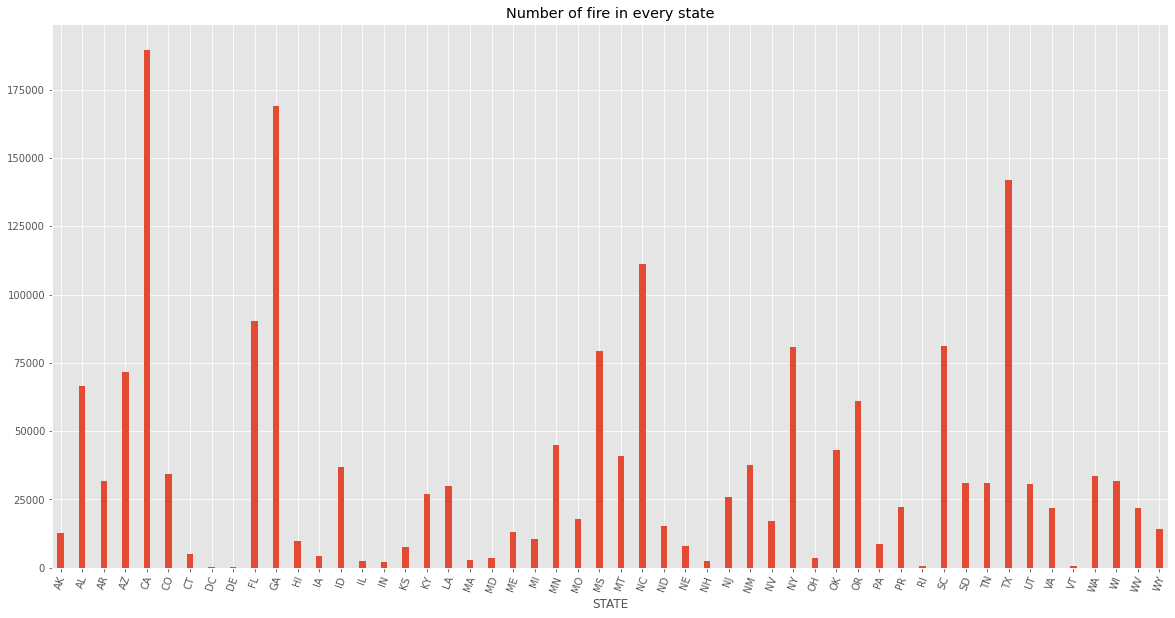

In [5]:
# Check the distribution of fires between the states
fire_state = df.pivot_table(index=['STATE'],aggfunc='size')
# print(fire_state)
plt.figure(figsize=(20, 10))
fire_state.plot.bar(rot=70 ,align='center', width=0.3 ,title="Number of fire in every state")
plt.show()

## Case study California wildfires
We decided to focus on South California which has a lote of fires in an area size we can manage  

### Creating a df for california fires

In [6]:
CA_df = df.loc[df['STATE'] == 'CA']
# CA_df.to_csv(r'data\California_fires.csv')
CA_df.head()

OBJECTID  FOD_ID      FPA_ID SOURCE_SYSTEM_TYPE SOURCE_SYSTEM  \
0         1       1  FS-1418826                FED   FS-FIRESTAT   
1         2       2  FS-1418827                FED   FS-FIRESTAT   
2         3       3  FS-1418835                FED   FS-FIRESTAT   
3         4       4  FS-1418845                FED   FS-FIRESTAT   
4         5       5  FS-1418847                FED   FS-FIRESTAT   

  NWCG_REPORTING_AGENCY NWCG_REPORTING_UNIT_ID  NWCG_REPORTING_UNIT_NAME  \
0                    FS                USCAPNF    Plumas National Forest   
1                    FS                USCAENF  Eldorado National Forest   
2                    FS                USCAENF  Eldorado National Forest   
3                    FS                USCAENF  Eldorado National Forest   
4                    FS                USCAENF  Eldorado National Forest   

  SOURCE_REPORTING_UNIT SOURCE_REPORTING_UNIT_NAME  ... FIRE_SIZE_CLASS  \
0                  0511     Plumas National Forest  ...               A   
1                  0503   Eldorado National Forest  ...               A   
2                  0503   Eldorado National Forest  ...               A   
3                  0503   Eldorado National Forest  ...               A   
4                  0503   Eldorado National Forest  ...               A   

    LATITUDE   LONGITUDE OWNER_CODE       OWNER_DESCR STATE COUNTY FIPS_CODE  \
0  40.036944 -121.005833        5.0              USFS    CA     63       063   
1  38.933056 -120.404444        5.0              USFS    CA     61       061   
2  38.984167 -120.735556       13.0  STATE OR PRIVATE    CA     17       017   
3  38.559167 -119.913333        5.0              USFS    CA      3       003   
4  38.559167 -119.933056        5.0              USFS    CA      3       003   

   FIPS_NAME                                              Shape  
0     Plumas  b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...  
1     Placer  b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...  
2  El Dorado  b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...  
3     Alpine  b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...  
4     Alpine  b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...  

[5 rows x 39 columns]

In [20]:

CA_fires = pd.read_csv(r'data\California_fires.csv')

In [21]:
# create GeoDataFrame
locations = gpd.points_from_xy(x=CA_fires.LONGITUDE, y=CA_fires.LATITUDE)
CA_fires['geometry'] = locations
CA_fires.head()
geo_fires = gpd.GeoDataFrame(CA_fires, geometry='geometry', crs="EPSG:4326")

### California fires Heat map

In [22]:
map_CA = folium.Map(location=[geo_fires["LATITUDE"].mean(), geo_fires["LONGITUDE"].mean()],
                    tiles = "Stamen Terrain",
                    zoom_start = 6)


heat_df2 = geo_fires[["LATITUDE","LONGITUDE", "FIRE_YEAR", "FIRE_SIZE"]]
# limit number of points, to get a processible result
heat_df2 = heat_df2[heat_df2["FIRE_SIZE"] > 1800]
heat_df2 = heat_df2.dropna(axis=0, subset=["LATITUDE","LONGITUDE"])

# List comprehension to make out list of lists
heat_data2 = [[row["LATITUDE"],row["LONGITUDE"]] for index, row in heat_df2.iterrows()]
del heat_df2

# Plot it on the map
HeatMap(heat_data2, min_opacity=.4, max_val=.8).add_to(map_CA)

# Display the map
map_CA

### The wildfires dataset cover the years 1992-2015,
### while the weather dataset begins in Oct' 2012 and ends in 2017.
### So we got an overlap between Oct' 2012 to the end of 2015.

### Also we decided to reduce the prediction area between LAT 32 to 35 so it will be more manageble on our computers 
### That leaves us with about 6000 fires

In [23]:
geo_fires_small = geo_fires.loc[(geo_fires['LATITUDE'] >= 32) & (geo_fires['LATITUDE'] <= 35)
                                & (geo_fires['FIRE_YEAR'] >= 2012) & (geo_fires['FIRE_YEAR'] <= 2015)]

In [30]:
# save to shapefile
# geo_fires_small.to_file(r'data\shp\fires_2012-15.shp')
geo_fires_small.head()

Unnamed: 0  OBJECTID     FOD_ID                  FPA_ID  \
81      1815776   1815777  300233249  SFO-2015CACDFORC000943   
96      1626261   1626262  201662157   SFO-CA-2012-RRU075652   
109     1626070   1626071  201661948   SFO-CA-2012-RRU057220   
124     1659922   1659923  201819511  SFO-2013CACDFRRU104973   
125     1652179   1652180  201810505  SFO-2013CACDFORC002981   

    SOURCE_SYSTEM_TYPE SOURCE_SYSTEM NWCG_REPORTING_AGENCY  \
81              NONFED       ST-NASF                ST/C&L   
96              NONFED       ST-NASF                ST/C&L   
109             NONFED       ST-NASF                ST/C&L   
124             NONFED       ST-NASF                ST/C&L   
125             NONFED       ST-NASF                ST/C&L   

    NWCG_REPORTING_UNIT_ID       NWCG_REPORTING_UNIT_NAME  \
81                 USCAORC  Orange County Fire Department   
96                 USCARRU                 Riverside Unit   
109                USCARRU                 Riverside Unit   
124                USCARRU                 Riverside Unit   
125                USCAORC  Orange County Fire Department   

    SOURCE_REPORTING_UNIT  ...   LATITUDE   LONGITUDE OWNER_CODE  \
81                  CAORC  ...  33.754116 -118.002718       14.0   
96                  CARRU  ...  33.997043 -117.485499       14.0   
109                 CARRU  ...  33.774780 -117.261121       14.0   
124                 CARRU  ...  33.783733 -116.999467       14.0   
125                 CAORC  ...  33.770651 -117.876096       14.0   

               OWNER_DESCR STATE     COUNTY FIPS_CODE  FIPS_NAME  \
81   MISSING/NOT SPECIFIED    CA     ORANGE      59.0     Orange   
96   MISSING/NOT SPECIFIED    CA  RIVERSIDE      65.0  Riverside   
109  MISSING/NOT SPECIFIED    CA  RIVERSIDE      65.0  Riverside   
124  MISSING/NOT SPECIFIED    CA  RIVERSIDE      65.0  Riverside   
125  MISSING/NOT SPECIFIED    CA     ORANGE      59.0     Orange   

                                                 Shape  \
81   b'\x00\x01\xad\x10\x00\x00\x10G\x1e\x88,\x80]\...   
96   b'\x00\x01\xad\x10\x00\x00d\xcfej\x12_]\xc0`\x...   
109  b'\x00\x01\xad\x10\x00\x00\x1c\xd3\xda4\xb6P]\...   
124  b'\x00\x01\xad\x10\x00\x00\x98\x9boD\xf7?]\xc0...   
125  b'\x00\x01\xad\x10\x00\x00\x00\n\xf5\xf4\x11x]...   

                        geometry  
81   POINT (-118.00272 33.75412)  
96   POINT (-117.48550 33.99704)  
109  POINT (-117.26112 33.77478)  
124  POINT (-116.99947 33.78373)  
125  POINT (-117.87610 33.77065)  

[5 rows x 41 columns]

# Building geographic data stracture  
We are dividing our area to cells of size 10kmX10km.  
Each row of our df will represent a cell in a specific weak of a specific year. Each cell contains the features of the cell area and if their was a fire inside it in that week in that year.

We created the cells in QGIS by splitting SRTM tiles to 10X10 cells and converting to polygons.


### We can see here our geographic cells and the fires(red circles)

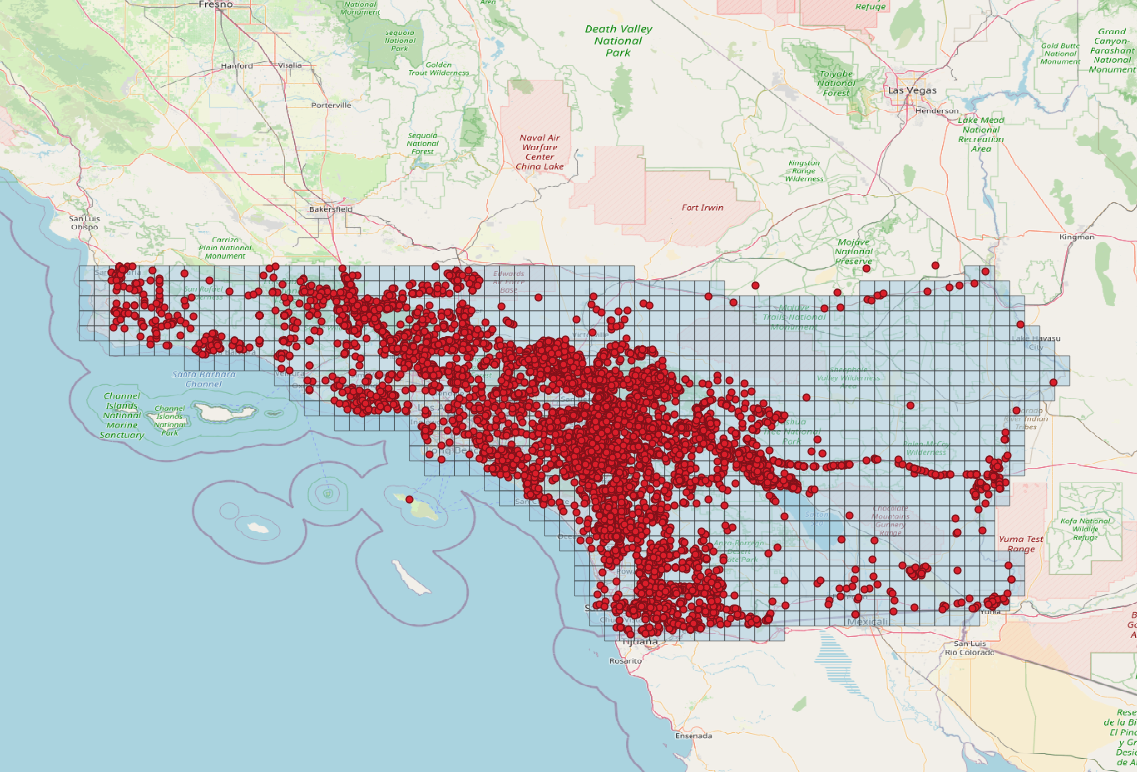

In [4]:
display(Image(filename='figures/cells.png'))

In [25]:
# load cells polygons
geo_cells = gpd.read_file(r'data\cells_polygons_california_only.shp',crs="EPSG:4326")
geo_cells.head()

geo_cells = geo_cells.drop(columns=['path','layer'])
geo_cells.head()

fid                                           location  \
0  1.0  C:/Users/Dell/OneDrive - Technion/××× ×××...   
1  2.0  C:/Users/Dell/OneDrive - Technion/××× ×××...   
2  3.0  C:/Users/Dell/OneDrive - Technion/××× ×××...   
3  4.0  C:/Users/Dell/OneDrive - Technion/××× ×××...   
4  5.0  C:/Users/Dell/OneDrive - Technion/××× ×××...   

                                            geometry  
0  POLYGON ((-115.00042 33.00042, -114.90042 33.0...  
1  POLYGON ((-114.90042 33.00042, -114.80042 33.0...  
2  POLYGON ((-114.80042 33.00042, -114.70042 33.0...  
3  POLYGON ((-114.70042 33.00042, -114.60042 33.0...  
4  POLYGON ((-114.60042 33.00042, -114.50042 33.0...

In [26]:
# load fires data
fires = gpd.read_file(r'data\fires_2012-15.shp',crs="EPSG:4326")
fires.head()

Unnamed_ 0  OBJECTID     FOD_ID      FPA_ID SOURCE_SYS   SOURCE_S_1  \
0     1567432   1567433  201433714  FS-1503920        FED  FS-FIRESTAT   
1     1567433   1567434  201433715  FS-1507944        FED  FS-FIRESTAT   
2     1567434   1567435  201433716  FS-1510402        FED  FS-FIRESTAT   
3     1567435   1567436  201433717  FS-1503567        FED  FS-FIRESTAT   
4     1567436   1567437  201433718  FS-1504047        FED  FS-FIRESTAT   

  NWCG_REPOR NWCG_REP_1               NWCG_REP_2 SOURCE_REP  ...   LATITUDE  \
0         FS    USCAANF  Angeles National Forest       0501  ...  34.204167   
1         FS    USCAANF  Angeles National Forest       0501  ...  34.345278   
2         FS    USCAANF  Angeles National Forest       0501  ...  34.548056   
3         FS    USCAANF  Angeles National Forest       0501  ...  34.174722   
4         FS    USCAANF  Angeles National Forest       0501  ...  34.489444   

    LONGITUDE OWNER_CODE             OWNER_DESC STATE COUNTY FIPS_CODE  \
0 -117.808333        5.0                   USFS    CA    037      37.0   
1 -117.928889        5.0                   USFS    CA    037      37.0   
2 -118.671667        5.0                   USFS    CA    037      37.0   
3 -117.672500        5.0                   USFS    CA    071      71.0   
4 -118.285833       14.0  MISSING/NOT SPECIFIED    CA    037      37.0   

        FIPS_NAME                                              Shape  \
0     Los Angeles  b'\x00\x01\xad\x10\x00\x00x\'\xb8\xbb\xbbs]\xc...   
1     Los Angeles  b'\x00\x01\xad\x10\x00\x00\xb8\nc\xear{]\xc0`\...   
2     Los Angeles  b'\x00\x01\xad\x10\x00\x00\xa4]3\x96\xfc\xaa]\...   
3  San Bernardino  b'\x00\x01\xad\x10\x00\x00\xd4\xa3p=\nk]\xc0pd...   
4     Los Angeles  b'\x00\x01\xad\x10\x00\x008\x1d\xe1\x17K\x92]\...   

                      geometry  
0  POINT (-117.80833 34.20417)  
1  POINT (-117.92889 34.34528)  
2  POINT (-118.67167 34.54806)  
3  POINT (-117.67250 34.17472)  
4  POINT (-118.28583 34.48944)  

[5 rows x 41 columns]

# Feature engineering

## Topographic data  
We downloaded dem tiles from the SRTM project in 90X90 meter resulution. Each tile is 1X1 geographic degree, that is about 100X100 km. So we divided each tiles to 100 smaller tiles and that gave us our 10X10 km polygons.  
Now we are using these tiles to get topographic statistics for each cell. We are using GDAL to open the dem's and calculate the statistics.

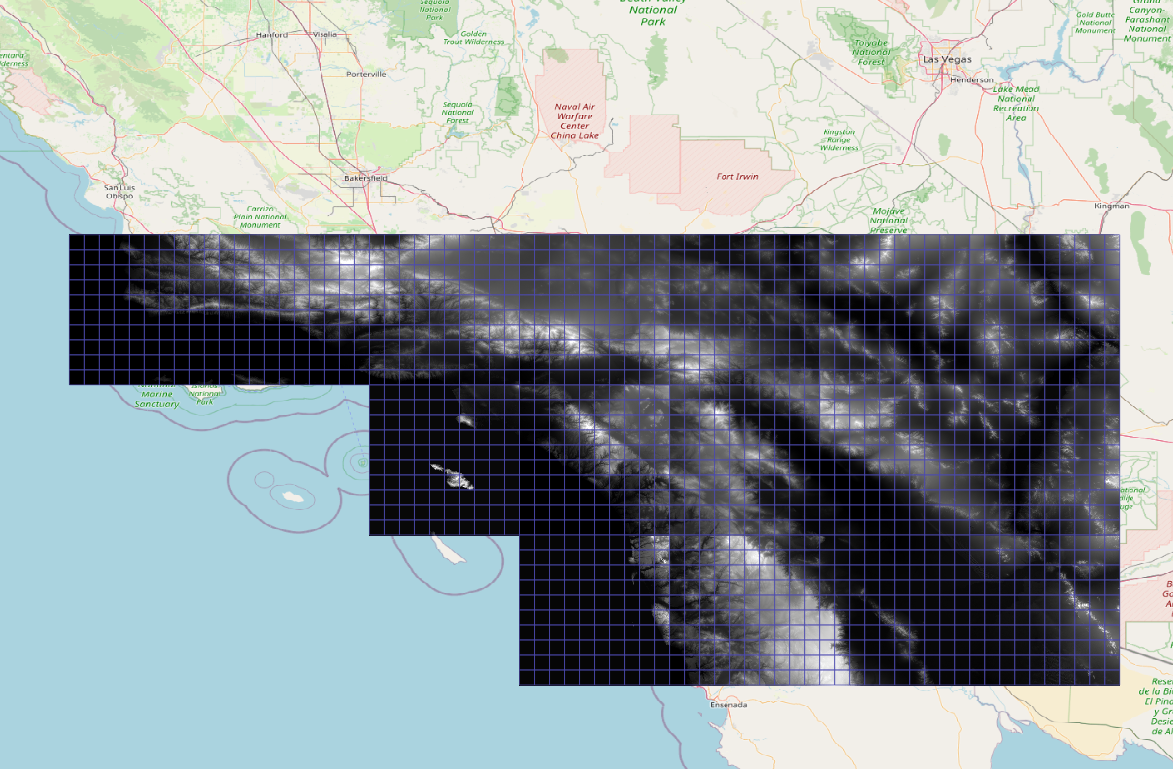

In [5]:
display(Image(filename='figures/DEM.png'))

### Calculate statistics

In [27]:
# calculate topographic statistics for each cell
for i, cell in geo_cells.iterrows():
    path = str(cell['location'][str.find(cell['location'],'data'):])
    raster = gdal.Open(path)
    band = raster.GetRasterBand(1)
    stats = band.ComputeStatistics(0)
    geo_cells.at[i,'min_height'] = stats[0]
    geo_cells.at[i,'max_height'] = stats[1]
    geo_cells.at[i,'avg_height'] = stats[2]
    geo_cells.at[i,'std_height'] = stats[3]

geo_cells.head()

fid                                           location  \
0  1.0  C:/Users/Dell/OneDrive - Technion/××× ×××...   
1  2.0  C:/Users/Dell/OneDrive - Technion/××× ×××...   
2  3.0  C:/Users/Dell/OneDrive - Technion/××× ×××...   
3  4.0  C:/Users/Dell/OneDrive - Technion/××× ×××...   
4  5.0  C:/Users/Dell/OneDrive - Technion/××× ×××...   

                                            geometry  min_height  max_height  \
0  POLYGON ((-115.00042 33.00042, -114.90042 33.0...        91.0       214.0   
1  POLYGON ((-114.90042 33.00042, -114.80042 33.0...       141.0       463.0   
2  POLYGON ((-114.80042 33.00042, -114.70042 33.0...       165.0       592.0   
3  POLYGON ((-114.70042 33.00042, -114.60042 33.0...        61.0       521.0   
4  POLYGON ((-114.60042 33.00042, -114.50042 33.0...        48.0       400.0   

   avg_height  std_height  
0  148.968819   25.747558  
1  205.685903   34.354413  
2  246.467083   33.330296  
3  230.628333   47.022054  
4  164.990556   49.978685

In [31]:
# save
# geo_cells.to_file(r'data\shp\geo_cells_basic.shp',crs="EPSG:4326")


## Manege weather data

We got an hourly weather datasets of about 30 cities around the world.
The relevant data is temperature, humidity, pressure and wind speed.
We found 3 cities that covers our case study area - Los Angeles, San Diego and Las Vegas.

first we are going to change the dataset to weekly basis (because we want to make weekly predictions),
then we are going to find the closest city for every cell to get the relevant values

In [32]:
def weeklyWeather(file_path):
    """
    Get hourly weather data and return weekly data
    :param file_path: CSV file path
    :return: DataFrame of weekly weather in Los Angeles, San Diego and Las Vegas
    """

    # read csv data
    df = pd.read_csv(file_path)
    df = df[['datetime','Los Angeles', 'San Diego', 'Las Vegas']]
    # convert to date feature
    df['datetime'] = pd.to_datetime(df['datetime'])
    # extract years months and weeks from the date features
    df['year']= df['datetime'].dt.year
    df['month']= df['datetime'].dt.month
    df['week_of_year'] = df['datetime'].dt.week
    # take data only between years 2012-2015
    df = df.loc[(df['year'] >= 2012) & (df['year'] <= 2015)]
    # solve a specific case when the last days of one year counts in the 'week_of_year' of the next year
    df.loc[(df['month'] == 12) & (df['week_of_year'] == 1) , 'year'] += 1
    df.drop(columns=['month'], inplace=True )
    # calculate the average weather value of every week
    return df.groupby(['year','week_of_year'],as_index=False).mean()

In [34]:
temperature = weeklyWeather(r'data\weather\temperature.csv')
humidity = weeklyWeather(r'data\weather\humidity.csv')
pressure = weeklyWeather(r'data\weather\pressure.csv')
wind_speed = weeklyWeather(r'data\weather\wind_speed.csv')

In [35]:
# save CSV
# temperature.to_csv(r'data\weekly_weather\temperature_weekly.csv')
# humidity.to_csv(r'data\weekly_weather\humidity_weekly.csv')
# pressure.to_csv(r'data\weekly_weather\pressure_weekly.csv')
# wind_speed.to_csv(r'data\weekly_weather\wind_speed_weekly.csv')

In [39]:
# read weather
temperature = pd.read_csv(r'data\weekly_weather\temperature_weekly.csv')
humidity = pd.read_csv(r'data\weekly_weather\humidity_weekly.csv')
pressure = pd.read_csv(r'data\weekly_weather\pressure_weekly.csv')
wind_speed= pd.read_csv(r'data\weekly_weather\wind_speed_weekly.csv')
wind_speed.head()

Unnamed: 0  year  week_of_year  Los Angeles  San Diego  Las Vegas
0           0  2012            40     0.438710   1.187097   1.645161
1           1  2012            41     0.851190   2.154762   2.458333
2           2  2012            42     0.565476   2.005952   1.297619
3           3  2012            43     0.625000   1.869048   4.636905
4           4  2012            44     0.327381   1.392857   1.095238

### Find the nearest city to every cell

In [37]:
def nearest(row, gdf1, gdf2, geom_col1,geom_col2, src_column=None):
    """
    Find the nearest point and return the corresponding value from specified column
    :param row: row of gdf1
    :param gdf1: GeoDataFrame of points that we want to find their nearest point from gdf2
    :param gdf2: GeoDataFrame of points that we want to find the nearest point for them from gdf1
    :param geom_col1: Name of geometry column in df1
    :param geom_col2: Name of geometry column in df2
    :param src_column: Name of the column that contain the values
    :return: The values of the nearest points in new column of gdf1
    """
    geom_union = gdf2.geometry.unary_union
    # Find the geometry that is closest
    nearest_ = gdf2[geom_col2] == nearest_points(row[geom_col1], geom_union)[1]
    # Get the corresponding value from df2 (matching is based on the geometry)
    value = gdf2.loc[nearest_,src_column].to_numpy()[0]
    return value

In [40]:
# read cities weather
df2 = pd.read_csv(r'data\cities_weather.csv')
locations_points = gpd.points_from_xy(x=df2.lon, y=df2.lat)
df2['geometry'] = locations_points

cities = gpd.GeoDataFrame(df2, geometry='geometry', crs="EPSG:4326")
cities.head()

city        lat         lon                     geometry
0  Los Angeles  34.052231 -118.243683  POINT (-118.24368 34.05223)
1    San Diego  32.715328 -117.157257  POINT (-117.15726 32.71533)
2    Las Vegas  36.174969 -115.137222  POINT (-115.13722 36.17497)

In [42]:
# read cells
geo_cells = gpd.read_file(r'data\shp\geo_cells_basic.shp',crs="EPSG:4326")
geo_cells.head()

fid                                           location  min_height  \
0  1.0  C:/Users/Dell/OneDrive - Technion/××× ×××...        91.0   
1  2.0  C:/Users/Dell/OneDrive - Technion/××× ×××...       141.0   
2  3.0  C:/Users/Dell/OneDrive - Technion/××× ×××...       165.0   
3  4.0  C:/Users/Dell/OneDrive - Technion/××× ×××...        61.0   
4  5.0  C:/Users/Dell/OneDrive - Technion/××× ×××...        48.0   

   max_height  avg_height  std_height  \
0       214.0  148.968819   25.747558   
1       463.0  205.685903   34.354413   
2       592.0  246.467083   33.330296   
3       521.0  230.628333   47.022054   
4       400.0  164.990556   49.978685   

                                            geometry  
0  POLYGON ((-115.00042 33.00042, -114.90042 33.0...  
1  POLYGON ((-114.90042 33.00042, -114.80042 33.0...  
2  POLYGON ((-114.80042 33.00042, -114.70042 33.0...  
3  POLYGON ((-114.70042 33.00042, -114.60042 33.0...  
4  POLYGON ((-114.60042 33.00042, -114.50042 33.0...

In [43]:
# find centroid of every cell's polygon
# projection to epsg=3310
proj_cells = geo_cells.to_crs(epsg=3310)
# calc centroids
proj_cells['centroid'] = proj_cells.centroid
# projection back to epsg=4326 (geographic)
centroid_4326 = proj_cells.centroid.to_crs(epsg=4326)
geo_cells['centroid'] = centroid_4326


In [44]:
# find cells's nearest city
geo_cells['nearest city'] = geo_cells.apply(nearest, gdf1=geo_cells,
                                                        gdf2=cities, geom_col1='centroid',geom_col2='geometry' , src_column='city', axis=1)

In [45]:
# Check the number of closed points fot every city
closed_cities = geo_cells.pivot_table(index=['nearest city'], aggfunc='size')
closed_cities

nearest city
Las Vegas      182
Los Angeles    426
San Diego      432
dtype: int64

In [46]:
# saving to shapefile
# remove the centroid column to stay with only one geometric column
geo_cells.drop('centroid', axis=1, inplace=True)
geo_cells.head()
# save
# geo_cells.to_file(r'data\shp\geo_cells_with_cities.shp')

fid                                           location  min_height  \
0  1.0  C:/Users/Dell/OneDrive - Technion/××× ×××...        91.0   
1  2.0  C:/Users/Dell/OneDrive - Technion/××× ×××...       141.0   
2  3.0  C:/Users/Dell/OneDrive - Technion/××× ×××...       165.0   
3  4.0  C:/Users/Dell/OneDrive - Technion/××× ×××...        61.0   
4  5.0  C:/Users/Dell/OneDrive - Technion/××× ×××...        48.0   

   max_height  avg_height  std_height  \
0       214.0  148.968819   25.747558   
1       463.0  205.685903   34.354413   
2       592.0  246.467083   33.330296   
3       521.0  230.628333   47.022054   
4       400.0  164.990556   49.978685   

                                            geometry nearest city  
0  POLYGON ((-115.00042 33.00042, -114.90042 33.0...    San Diego  
1  POLYGON ((-114.90042 33.00042, -114.80042 33.0...    San Diego  
2  POLYGON ((-114.80042 33.00042, -114.70042 33.0...    San Diego  
3  POLYGON ((-114.70042 33.00042, -114.60042 33.0...    San Diego  
4  POLYGON ((-114.60042 33.00042, -114.50042 33.0...    San Diego

### Cells coloured by nearest city with weather data

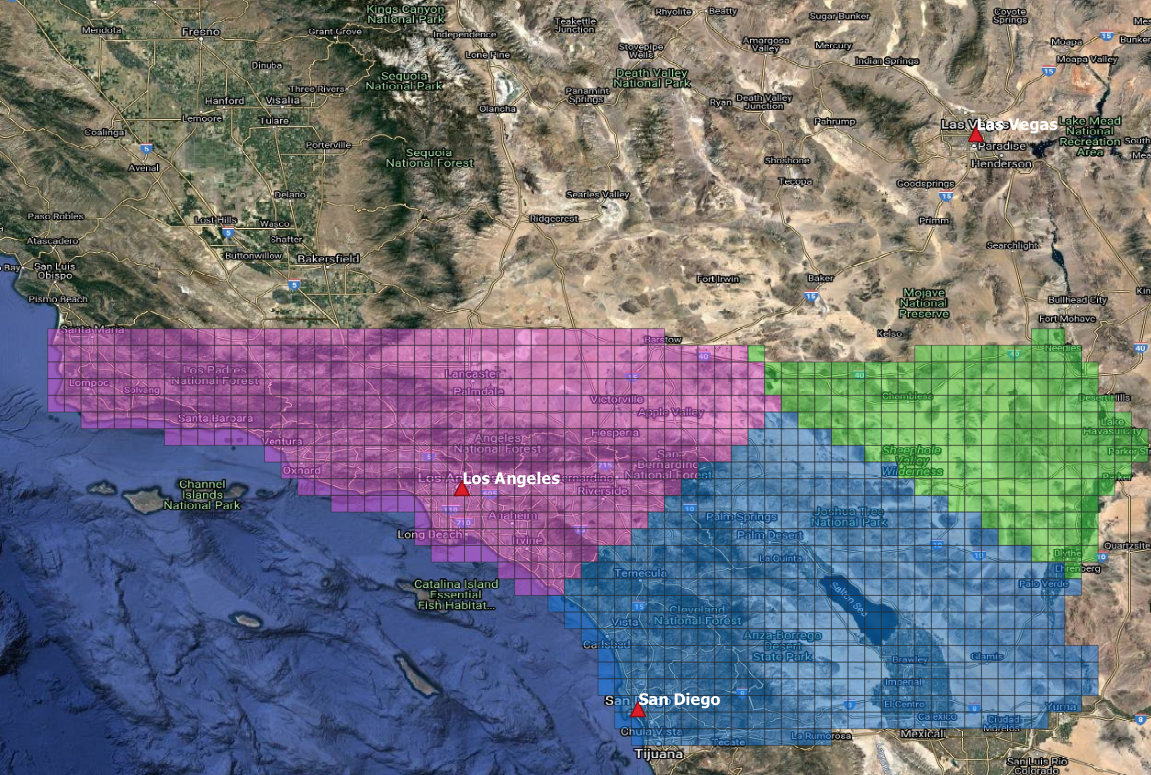

In [5]:
display(Image(filename='figures/nearestCity.png'))

# Weeks in every year
We are duplicating our basic cells stracture so we will have every geographic cell in every week of every year and then we will insert the corresponding weather data

In [47]:
# read
fires = gpd.read_file(r'data\shp\fires_2012-15.shp',crs="EPSG:4326")
geo_cells = gpd.read_file(r'data\shp\geo_cells_with_cities.shp')

In [48]:
geo_cells_with_weeks = geo_cells.copy()
geo_cells_with_weeks['week'] = 39
geo_cells_with_weeks['year'] = 2012

In [49]:
# for 2012

for i in range(40,52):
    gd = geo_cells.copy()
    gd['week'] = i
    gd['year'] = 2012
    geo_cells_with_weeks = geo_cells_with_weeks.append(gd)

In [50]:
# for 2013-2015

for j in range (2013,2016):
    for i in range(0,52):
        gd = geo_cells.copy()
        gd['week'] = i
        gd['year'] = j
        geo_cells_with_weeks = geo_cells_with_weeks.append(gd)

geo_cells_with_weeks.reset_index(drop=True, inplace=True)

### Long running time

In [51]:
# long running time #

# fitting fires to cells in year 2012
# for i in range(39,52):
#     temp_fires = fires[fires['FIRE_YEAR']==2012]
#     temp_fires = temp_fires[fires['DISCOVER_1']//7==i]
#     for j, row in geo_cells.iterrows():
#         pip = temp_fires.within((geo_cells.loc[j,'geometry'])) # check if inside cell
#         fire_in_cell = temp_fires[pip==True]
#         if fire_in_cell.shape[0] >0 : # case of fire in cell
#             index = j + (i-39)*geo_cells.shape[0] # finding the index of the right cell
#             geo_cells_with_weeks.at[index,'fire'] = 1

In [52]:
# fitting fires to cells in years 2013-2015
# for y in range(2013,2016):
#     for i in range(52):
#         temp_fires = fires[fires['FIRE_YEAR']==y]
#         temp_fires = temp_fires[fires['DISCOVER_1']//7==i]
#         for j, row in geo_cells.iterrows():
#             pip = temp_fires.within((geo_cells.loc[j,'geometry'])) # check if inside cell
#             fire_in_cell = temp_fires[pip==True]
#             if fire_in_cell.shape[0] >0 : # case of fire in cell
#                 index = j + i*geo_cells.shape[0] + 13*geo_cells.shape[0] + ((y-2013)*52*geo_cells.shape[0]) # finding the index of the right cell
#                 geo_cells_with_weeks.at[index,'fire'] = 1

In [53]:
#save to shp
# geo_cells_with_weeks.to_file(r'results\shp\geo_cells_with_weeksANDcities.shp')


fid                                           location  min_height  \
0  1.0  C:/Users/Dell/OneDrive - Technion/××× ×××...        91.0   
1  2.0  C:/Users/Dell/OneDrive - Technion/××× ×××...       141.0   
2  3.0  C:/Users/Dell/OneDrive - Technion/××× ×××...       165.0   
3  4.0  C:/Users/Dell/OneDrive - Technion/××× ×××...        61.0   
4  5.0  C:/Users/Dell/OneDrive - Technion/××× ×××...        48.0   

   max_height  avg_height  std_height nearest ci  \
0       214.0  148.968819   25.747558  San Diego   
1       463.0  205.685903   34.354413  San Diego   
2       592.0  246.467083   33.330296  San Diego   
3       521.0  230.628333   47.022054  San Diego   
4       400.0  164.990556   49.978685  San Diego   

                                            geometry  week  year  fire  
0  POLYGON ((-115.00042 33.00042, -114.90042 33.0...    39  2012   NaN  
1  POLYGON ((-114.90042 33.00042, -114.80042 33.0...    39  2012   NaN  
2  POLYGON ((-114.80042 33.00042, -114.70042 33.0...    39  2012   NaN  
3  POLYGON ((-114.70042 33.00042, -114.60042 33.0...    39  2012   NaN  
4  POLYGON ((-114.60042 33.00042, -114.50042 33.0...    39  2012   NaN

### Insert weather to cells

In [54]:
# read
geo_cells_with_weeks = gpd.read_file(r'data\shp\geo_cells_with_weeksANDcities.shp')
geo_cells_with_weeks.head()

In [55]:
def insert_weather_data(cells_df, weather_df):
    weather_name =[x for x in globals() if globals()[x] is weather_df][0]
    for i, row in weather_df.iterrows():
        for j in range(0,1040):
            city = cells_df.loc[j,'nearest ci']
            index = j + 1040*i
            if index < cells_df.shape[0]: # because the weeks's count of the weather different from the cell counts
                cells_df.loc[index,weather_name] = weather_df.loc[i,city]

### Long running time

In [58]:
# long running time #

# insert_weather_data(geo_cells_with_weeks,temperature)
# insert_weather_data(geo_cells_with_weeks,humidity)
# insert_weather_data(geo_cells_with_weeks,pressure)
# insert_weather_data(geo_cells_with_weeks,wind_speed)

In [59]:
# take only the relevant rows in case of extra rows
# cells_with_weather = geo_cells_with_weeks.loc[0:175759,:]

In [60]:
#save to shp
# cells_with_weather.to_file(r'data\shp\cells_with_weather.shp')
# cells_with_weather.head()

In [62]:
# read
cells_finish = gpd.read_file(r'data\shp\cells_with_weather.shp')
cells_finish.head()

fid                                           location  min_height  \
0  1.0  C:/Users/Dell/OneDrive - Technion/××× ×××...        91.0   
1  2.0  C:/Users/Dell/OneDrive - Technion/××× ×××...       141.0   
2  3.0  C:/Users/Dell/OneDrive - Technion/××× ×××...       165.0   
3  4.0  C:/Users/Dell/OneDrive - Technion/××× ×××...        61.0   
4  5.0  C:/Users/Dell/OneDrive - Technion/××× ×××...        48.0   

   max_height  avg_height  std_height nearest ci  week    year  fire  \
0       214.0  148.968819   25.747558  San Diego  39.0  2012.0   NaN   
1       463.0  205.685903   34.354413  San Diego  39.0  2012.0   NaN   
2       592.0  246.467083   33.330296  San Diego  39.0  2012.0   NaN   
3       521.0  230.628333   47.022054  San Diego  39.0  2012.0   NaN   
4       400.0  164.990556   49.978685  San Diego  39.0  2012.0   NaN   

   temperatur   humidity     pressure  wind_speed  \
0  294.500153  70.148387  1014.387097    1.187097   
1  294.500153  70.148387  1014.387097    1.187097   
2  294.500153  70.148387  1014.387097    1.187097   
3  294.500153  70.148387  1014.387097    1.187097   
4  294.500153  70.148387  1014.387097    1.187097   

                                            geometry  
0  POLYGON ((-115.00042 33.00042, -114.90042 33.0...  
1  POLYGON ((-114.90042 33.00042, -114.80042 33.0...  
2  POLYGON ((-114.80042 33.00042, -114.70042 33.0...  
3  POLYGON ((-114.70042 33.00042, -114.60042 33.0...  
4  POLYGON ((-114.60042 33.00042, -114.50042 33.0...

In [63]:
for index, row in cells_finish.iterrows():
    cells_finish.at[index,'ULcorner_Lat'] = row['geometry'].boundary.xy[1][0]
    cells_finish.at[index,'ULcorner_Long'] = row['geometry'].boundary.xy[0][0]

In [64]:
# cells_finish.to_file(r'data\shp\cells_finish.shp')
cells_finish.head()

fid                                           location  min_height  \
0  1.0  C:/Users/Dell/OneDrive - Technion/××× ×××...        91.0   
1  2.0  C:/Users/Dell/OneDrive - Technion/××× ×××...       141.0   
2  3.0  C:/Users/Dell/OneDrive - Technion/××× ×××...       165.0   
3  4.0  C:/Users/Dell/OneDrive - Technion/××× ×××...        61.0   
4  5.0  C:/Users/Dell/OneDrive - Technion/××× ×××...        48.0   

   max_height  avg_height  std_height nearest ci  week    year  fire  \
0       214.0  148.968819   25.747558  San Diego  39.0  2012.0   NaN   
1       463.0  205.685903   34.354413  San Diego  39.0  2012.0   NaN   
2       592.0  246.467083   33.330296  San Diego  39.0  2012.0   NaN   
3       521.0  230.628333   47.022054  San Diego  39.0  2012.0   NaN   
4       400.0  164.990556   49.978685  San Diego  39.0  2012.0   NaN   

   temperatur   humidity     pressure  wind_speed  \
0  294.500153  70.148387  1014.387097    1.187097   
1  294.500153  70.148387  1014.387097    1.187097   
2  294.500153  70.148387  1014.387097    1.187097   
3  294.500153  70.148387  1014.387097    1.187097   
4  294.500153  70.148387  1014.387097    1.187097   

                                            geometry  ULcorner_Lat  \
0  POLYGON ((-115.00042 33.00042, -114.90042 33.0...     33.000417   
1  POLYGON ((-114.90042 33.00042, -114.80042 33.0...     33.000417   
2  POLYGON ((-114.80042 33.00042, -114.70042 33.0...     33.000417   
3  POLYGON ((-114.70042 33.00042, -114.60042 33.0...     33.000417   
4  POLYGON ((-114.60042 33.00042, -114.50042 33.0...     33.000417   

   ULcorner_Long  
0    -115.000417  
1    -114.900417  
2    -114.800417  
3    -114.700417  
4    -114.600417